In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from mnist_model import generator,discriminator
import utils
l = tf.layers

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
"""
idea:
-add ema


conclusion:
-ambient reg on GAN samples is more powerful than unlabeled ambient reg (ie:GAN is a regularizer itself)
-0.001 *consistency_gan_loss

"""

'\nidea:\n-add ema\n\n\nconclusion:\n-ambient reg on GAN samples is more powerful than unlabeled ambient reg (ie:GAN is a regularizer itself)\n-0.001 *consistency_gan_loss\n\n'

In [3]:
def get_getter(ema):
    def ema_getter(getter, name, *args, **kwargs):
        var = getter(name, *args, **kwargs)
        ema_var = ema.average(var)
        return ema_var if ema_var else var
    return ema_getter

## Hyperparam

In [4]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 1e-4,
    logdir = 'gan_mnist/',
    name_model = 'model_latent100_fc'
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation (unl)

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
trainx_unl = trainx.copy()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build model

In [6]:
tf.reset_default_graph()

In [7]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])
iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

Tensor("discriminator/layer_3/leaky_relu/sub:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator_1/layer_3/leaky_relu/sub:0", shape=(100, 4, 4, 512), dtype=float32)


In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='my_scope')
saver = tf.train.Saver()

In [9]:
if tf.train.latest_checkpoint(os.path.join('./gan_mnist/')) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(os.path.join('./gan_mnist/')))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_mnist/model_latent100_fc


In [2]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 500
lsd=[]
lsg=[]
for i in tqdm(range(10001)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    ld,_=sess.run([loss_d,traind],{is_training_pl:True})
    lg,_=sess.run([loss_g, traing],{is_training_pl:True})
    lsd.append(ld); lsg.append(lg);

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:True})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()


NameError: name 'sess' is not defined

In [11]:
if not os.path.exists(params['logdir']):
    os.makedirs(params['logdir'])
saver.save(sess, os.path.join('./saved_models/',params['logdir'],params['name_model']))


ValueError: Parent directory of ./saved_models/gan_mnist/model_latent100_fc doesn't exist, can't save.

In [157]:
saver.save(sess, './efficient_model_saved/')


'./efficient_model_saved/'

## CNN

In [10]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.1, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=1e-4,
    beta1 = 0.9,
    epoch = 200,
    l2_w = 0.1,
    labeled = 10
)
rng = np.random.RandomState(params['seed'])  # seed labels

(100, 28, 28, 1) (10000, 28, 28, 1)


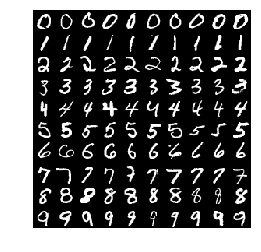

In [11]:
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']
print(trainx.shape,testx.shape)
show_digits(trainx[:])
plt.show()

## defining model

In [12]:
def lenet(x,training_pl,getter=None):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE, custom_getter=getter):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x
    
soft = lambda x: 1/(1+tf.exp(-x))    

In [13]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 28,28,1])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])

logits = lenet(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [67]:
################ AMBIANT GAN ##############
samp_logits1 = lenet(samples,training_cnn)
p1 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
samp_logits2 = lenet(samples + p1,training_cnn)
p3 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
samp_logits3 = lenet(samples + p3,training_cnn)

consistency_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits1-samp_logits2)+1e-8),axis=1)
consistency_gan_loss = tf.reduce_mean(consistency_gan)

ambient_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits3-samp_logits2)+1e-8),axis=1)
ambient_gan_loss = tf.reduce_mean(ambient_gan)

# ################ AMBIANT UNL #################

unl = tf.placeholder(tf.float32, [params['batch_size'], 28,28,1])
unl_logits1 = lenet(unl,training_cnn)
p2 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
unl_logits2 = lenet(unl+p2,training_cnn)


consistency_unl = tf.reduce_sum(tf.sqrt(tf.square(unl_logits1-unl_logits2)+1e-8),axis=1)
consistency_unl_loss = tf.reduce_mean(consistency_unl)

kl_gan = kl_divergence_with_logit(samp_logits1,samp_logits2)
kl_unl = kl_divergence_with_logit(unl_logits1,unl_logits2)


# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 10* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3]) + pz

logits_z1= lenet(samp_z1,training_cnn)
logits_z2 = lenet(samp_z2+pz,training_cnn)
logits_adv = lenet(samp_adv,training_cnn)

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)


loss = xloss #+ 0.001 * manifold_loss
#+ .0 * consistency_gan_loss + 0. * consistency_unl_loss # + 1. * kl_unl 
#0.001 *consistency_gan_loss

In [68]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})

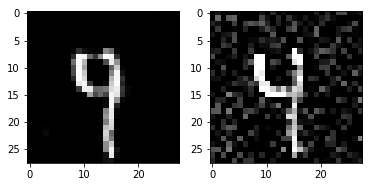

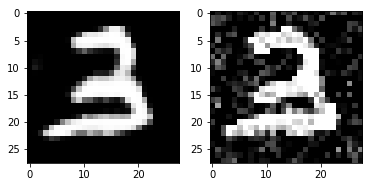

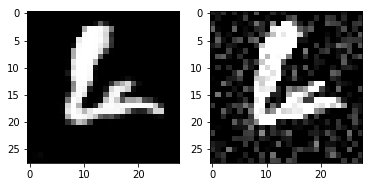

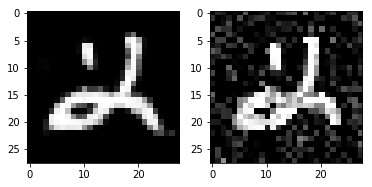

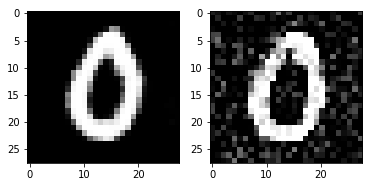

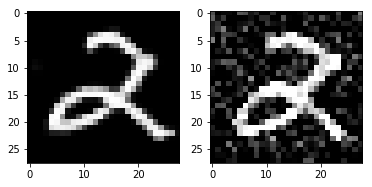

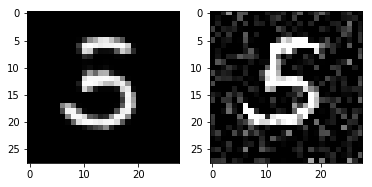

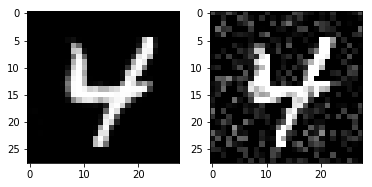

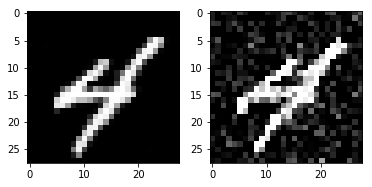

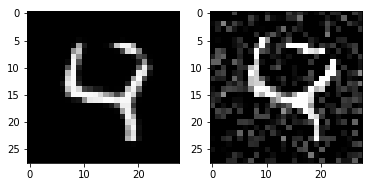

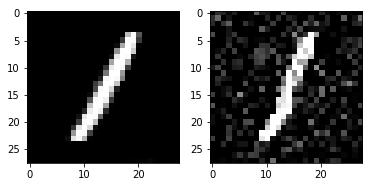

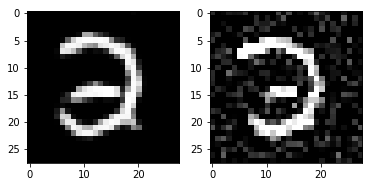

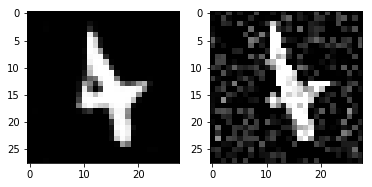

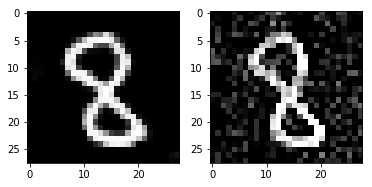

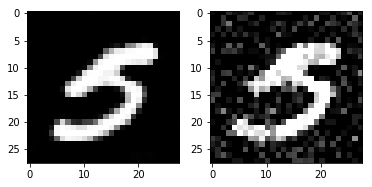

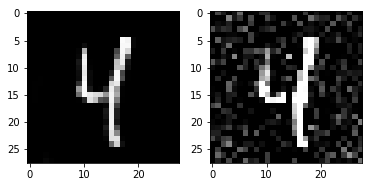

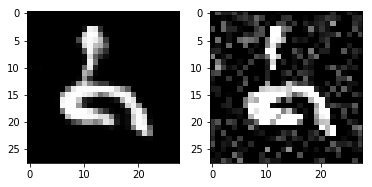

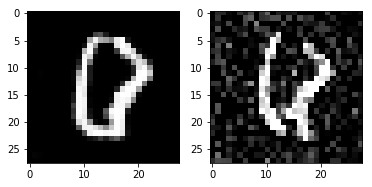

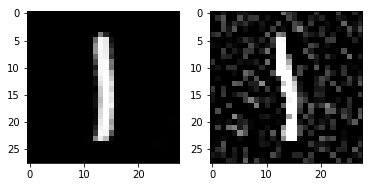

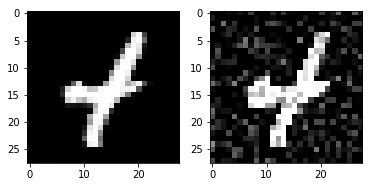

In [69]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]),cmap='gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]),cmap='gray',vmin=0,vmax=1)
    plt.show()

In [70]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))

    correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [71]:
def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 

In [72]:
ema = tf.train.ExponentialMovingAverage(decay=0.999)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

logits_ema = lenet(inp, training_cnn, getter=ema_getter)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),lbl)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

ValueError: Variable classifier/conv2d/kernel/ExponentialMovingAverage/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-19-b502f8e8c2cb>", line 3, in <module>
    maintain_averages_op = ema.apply(dvars)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


In [73]:
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [74]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='ema')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [75]:
# [print(v.name) for v in tf.global_variables(scope='ema1')]

## cnn training

In [76]:
sess.run(init_op)

In [77]:
con_loss = []
test_array = [];test_ema = []

length_epoch = 1000
nr_batch_train = length_epoch // params_dnn['batch']
print(nr_batch_train)
print("epoch length:", length_epoch,", batch size:", params_dnn['batch'], 
      ", nr_batch_train:",nr_batch_train, ", mc size:", params['batch_size'],",total grad iter:",length_epoch * params_dnn['epoch'])
for epoch in tqdm(range(300)):
    train_acc=train_loss=test_acc=test_acc_ema=0
    trainx = [];trainy = []
    for t in range(int(np.ceil(length_epoch / float(txs.shape[0])))):  # same size lbl and unlb
        inds = np.random.permutation(txs.shape[0])
        trainx.append(txs[inds])
        trainy.append(tys[inds])
    trainx = np.concatenate(trainx, axis=0)
    trainy = np.concatenate(trainy, axis=0)
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
#     print(trainx.shape)
    for t in range(nr_batch_train):
#         print(t)
        ran_from = t * params_dnn['batch']
        ran_to = (t + 1) * params_dnn['batch']
        ran_from_mc = t * params['batch_size']
        ran_to_mc = (t + 1) * params['batch_size']
#         print(ran_from,ran_to)

        xl,_,acc,con = sess.run([xloss,train_op,accuracy,manifold_loss],feed_dict={inp: trainx[ran_from:ran_to],
                                                                 lbl: trainy[ran_from:ran_to],
                                                                 unl: trainx_unl[ran_from_mc:ran_to_mc],
                                                                 training_cnn:True,
                                                                 is_training_pl:False})
        train_acc += acc; train_loss += xl; 
        sess.run(maintain_averages_op)
        con_loss.append(con)
    train_acc /= nr_batch_train; train_loss /= nr_batch_train
    
    if epoch % 1 == 0:
        for t in range(nr_batch_test):
            ran_from = t * params_dnn['batch']
            ran_to = (t + 1) * params_dnn['batch']
            xl,acc, acc_ema = sess.run([xloss,accuracy, accuracy_ema],feed_dict={inp: testx[ran_from:ran_to],
                                                                     lbl: testy[ran_from:ran_to],
                                                                     training_cnn:False})
            test_acc += acc; test_acc_ema += acc_ema
        test_acc /= nr_batch_test; test_array.append(test_acc); test_acc_ema /= nr_batch_test; test_ema.append(test_acc_ema)
        print("Epoch: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%, test acc ema: {:.2f}%".format(
            epoch, train_loss, train_acc * 100,test_acc*100, test_acc_ema *100))


20
epoch length: 1000 , batch size: 50 , nr_batch_train: 20 , mc size: 100 ,total grad iter: 200000


Epoch: 0, xloss: 2.11596, training acc: 45.80%, test acc: 61.96%, test acc ema: 10.32%
Epoch: 1, xloss: 1.57262, training acc: 83.10%, test acc: 70.46%, test acc ema: 12.22%
Epoch: 2, xloss: 0.87814, training acc: 88.80%, test acc: 74.82%, test acc ema: 15.88%
Epoch: 3, xloss: 0.47394, training acc: 91.90%, test acc: 76.94%, test acc ema: 19.88%

Epoch: 4, xloss: 0.26495, training acc: 96.20%, test acc: 79.54%, test acc ema: 23.84%
Epoch: 5, xloss: 0.17728, training acc: 97.60%, test acc: 80.06%, test acc ema: 28.18%
Epoch: 6, xloss: 0.11472, training acc: 99.10%, test acc: 80.56%, test acc ema: 32.78%
Epoch: 7, xloss: 0.07308, training acc: 99.80%, test acc: 80.94%, test acc ema: 38.96%
Epoch: 8, xloss: 0.05774, training acc: 99.70%, test acc: 81.60%, test acc ema: 46.00%
Epoch: 9, xloss: 0.03942, training acc: 99.90%, test acc: 81.92%, test acc ema: 52.04%
Epoch: 10, xloss: 0.03024, training acc: 100.00%, test acc: 81.58%, test acc ema: 56.22%
Epoch: 11, xloss: 0.02432, training acc:

Epoch: 93, xloss: 0.00021, training acc: 100.00%, test acc: 82.64%, test acc ema: 82.44%
Epoch: 94, xloss: 0.00016, training acc: 100.00%, test acc: 82.60%, test acc ema: 82.42%
Epoch: 95, xloss: 0.00015, training acc: 100.00%, test acc: 82.48%, test acc ema: 82.48%
Epoch: 96, xloss: 0.00015, training acc: 100.00%, test acc: 82.50%, test acc ema: 82.48%
Epoch: 97, xloss: 0.00015, training acc: 100.00%, test acc: 82.68%, test acc ema: 82.44%
Epoch: 98, xloss: 0.00014, training acc: 100.00%, test acc: 82.74%, test acc ema: 82.46%
Epoch: 99, xloss: 0.00016, training acc: 100.00%, test acc: 82.66%, test acc ema: 82.46%
Epoch: 100, xloss: 0.00016, training acc: 100.00%, test acc: 82.58%, test acc ema: 82.46%
Epoch: 101, xloss: 0.00017, training acc: 100.00%, test acc: 82.74%, test acc ema: 82.44%
Epoch: 102, xloss: 0.00016, training acc: 100.00%, test acc: 82.60%, test acc ema: 82.48%
Epoch: 103, xloss: 0.00014, training acc: 100.00%, test acc: 81.92%, test acc ema: 82.42%
Epoch: 104, xloss

KeyboardInterrupt: 

In [78]:
# acc_kl_gan = test_array
# acc_vanilla = test_array
# acc_con_unl = test_array
# acc_con_unl_200 = test_array
# unl= test_array
# vanilla = test_array
# ema = test_ema
# manifold=test_array
# manifold_ema=test_ema
# mani_loss = con
# m = test_array
# gan_consist = test_array
# gan_unl = test_array
# manifold_ambient = test_array
# mani = test_array
vanille = test_array

(0.8, 0.9)

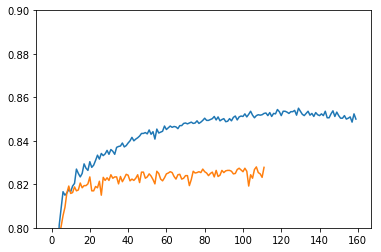

In [80]:
# plt.plot(acc_kl_gan)
# plt.plot(vanilla)
# plt.plot(gan_ambiant)
# plt.plot(acc_con_unl_200)
# plt.plot(unl200)
# plt.plot(gan200)
# plt.plot(unl)
# plt.plot(gan_consist)
plt.plot(mani)
plt.plot(vanille)
plt.ylim([0.80,0.90])

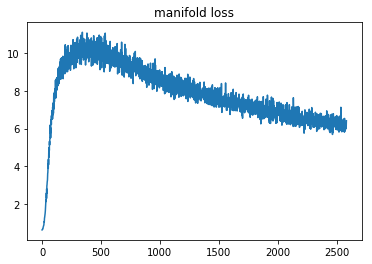

In [56]:
plt.plot(con_loss)
plt.title('manifold loss')
plt.show()

In [63]:
xx,yy=sess.run([samp_z1,samp_z2+pz],{is_training_pl:False})

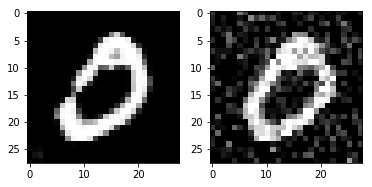

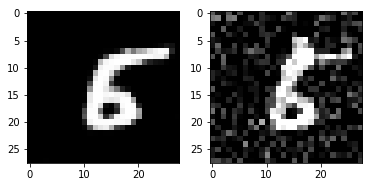

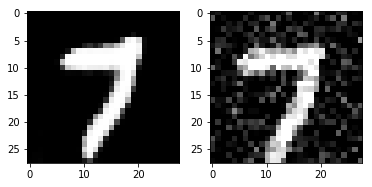

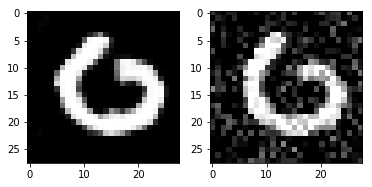

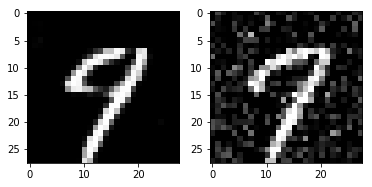

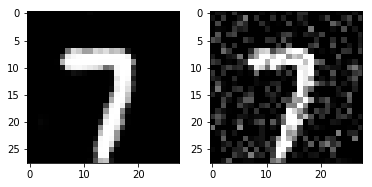

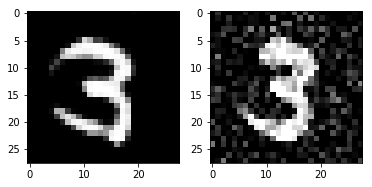

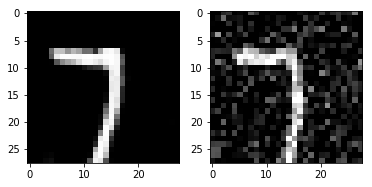

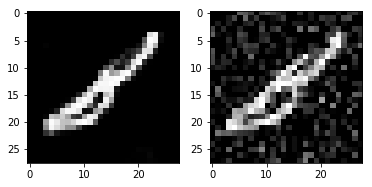

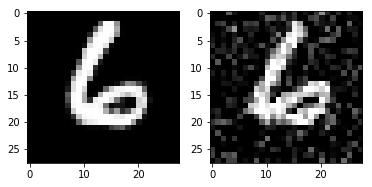

In [64]:
for idx in range(10):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]),cmap='gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]),cmap='gray',vmin=0,vmax=1)
    plt.show()

(0.77, 0.82)

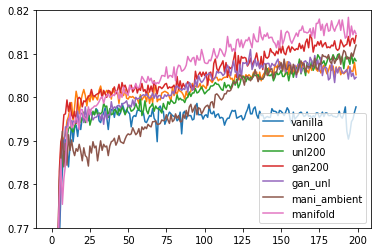

(0.77, 0.82)

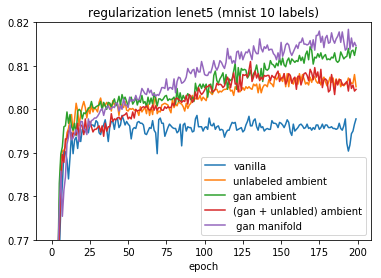

In [148]:
# plt.plot(acc_kl_gan)
plt.plot(acc_vanilla)
plt.plot(acc_con_unl_200)
# plt.plot(unl200)
plt.plot(gan200)
plt.plot(gan_unl)
# plt.plot(manifold_ambient)
plt.plot(manifold)
plt.legend(['vanilla','unlabeled ambient','gan ambient','(gan + unlabled) ambient',' gan manifold'])
plt.title('regularization lenet5 (mnist 10 labels)')
plt.xlabel('epoch')
plt.ylim([0.77,0.82])

In [ ]:
sess.run()

In [155]:
sess.run(manifold,{training_cnn:False,is_training_pl:False})

TypeError: Fetch argument 0.6134000024199486 has invalid type <class 'numpy.float64'>, must be a string or Tensor. (Can not convert a float64 into a Tensor or Operation.)

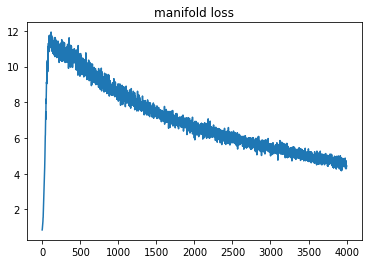

In [150]:
plt.plot(con_loss)
plt.title('manifold loss')
plt.show()

In [178]:
nr_batch_train

6000

In [167]:
np.asarray([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])

array([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])